#Maximum flow


Package import.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
import heapq

Graph representations.

In [2]:
def print_matrix(vertices, matrix):
  """
  Printing a graph given by adjacency matrix
  """
  n = len(matrix)
  if (vertices is not None) and (len(vertices) == n):
    vv = vertices
  else:
    vv = range(1, n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i, j]:
        print(" ", vv[j], end="")
    print("")

def print_dict(graph):
  """
  Printing of a graph (given as a dictionary/neighbouring list)
  """
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

Class *WeightedGraph* (Mandatory Set + Dinitz)

In [7]:
class WeightedGraph:
    def __init__(self):
        #diccionario clave-valor. Clave: Nodo, Valor: Lista de vecinos
        self.graph = {}
        #diccionario para guardar el peso/capacidad de cada flecha (arista)
        self.weights = {}
        #lista simple para saber qué nodos existen en orden
        self.vertices = []

    def add_vertex(self, vertex):
        if vertex not in self.graph:
            self.graph[vertex] = []
            self.vertices.append(vertex)

    def add_arc(self, arc, weight=1):
        u, v = arc #desempaquetamos: u es origen, v es destino
        self.add_vertex(u); self.add_vertex(v) #Aseguramos que existan
        #si v no está en la lista de vecinos de u, lo añadimos
        if v not in self.graph[u]:
            self.graph[u].append(v)
        self.weights[(u, v)] = weight #guardamos el peso de la conexión u -> v

    def copy(self):
        #crea una copia idéntica del grafo
        new_g = WeightedGraph()
        new_g.graph = deepcopy(self.graph)
        new_g.weights = deepcopy(self.weights)
        new_g.vertices = deepcopy(self.vertices)
        return new_g

    def get_matrix(self):
        #convierte el grafo de diccionario a matriz Numpy para visualización
        n = len(self.vertices)
        v_to_i = {v: i for i, v in enumerate(self.vertices)}
        matrix = np.zeros((n, n))
        #rellenamos la matriz con los pesos
        for (u, v), w in self.weights.items():
            if u in v_to_i and v in v_to_i:
                matrix[v_to_i[u]][v_to_i[v]] = w
        return matrix

    # =========================================================================
    # 1. MANDATORY: PRÜFER CODES
    # =========================================================================
    def prufer_code(self):
        """
        Busca siempre la hoja con el número más pequeño, anota su vecino en la lista y borra la hoja.
        Repite hasta que queden 2 nodos
        """
        #hacemos una copia porque vamos a destrozar el grafo
        tree = self.copy()
        code = []
        #el algoritmo se repite hasta que solo quedan 2 nodos
        while len(tree.vertices) > 2:
            #buscamos las hojas: nodos que solo tienen 1 vecino real
            leaves = [u for u in tree.vertices if len([v for v in tree.graph[u] if v in tree.graph]) == 1]
            if not leaves: break #seguridad por si no es un árbol válido
            leaf = min(leaves) #elegimos la hoja con etiqueta menor
            #encontramos quién es el único vecino de esa hoja
            neighbor = [v for v in tree.graph[leaf] if v in tree.graph][0]
            code.append(neighbor) #añadimos el vecino al código
            #eliminamos la hoja del grafo y de la lista de vértices
            del tree.graph[leaf]
            tree.vertices.remove(leaf)
            if leaf in tree.graph[neighbor]: tree.graph[neighbor].remove(leaf) #borramos también la conexión inversa si existe
        return code

    # =========================================================================
    # 2. MANDATORY: SEARCH (DFS / BFS)
    # =========================================================================
    def bfs(self, start_node):
        #array para no visitar dos veces el mismo sitio (evitar ciclos infinitos)
        visited = {v: False for v in self.vertices}
        queue = [start_node]; visited[start_node] = True; result = [] #cola: el primero que entra, es el primero que sale (FIFO)
        while queue:
            u = queue.pop(0); result.append(u) #sacamos el primero de la lista
            for v in self.graph[u]: #miramos vecinos
                if not visited[v]: visited[v] = True; queue.append(v) #lo ponemos a la cola
        return result

    def dfs(self, start_node):
        visited = {v: False for v in self.vertices}
        stack = [start_node]; result = [] #pila: el último que entra, es el primero que sale (LIFO)
        while stack:
            u = stack.pop() #sacamos el último
            if not visited[u]:
                visited[u] = True; result.append(u)
                #añadimos vecinos. Invertimos el orden para que salga de izquierda a derecha
                for v in reversed(self.graph[u]):
                    if not visited[v]: stack.append(v)
        return result

    # =========================================================================
    # 3. MANDATORY: APPLICATIONS (Acyclicity/Topo and Bipartiteness)
    # =========================================================================
    def is_bipartite(self):
        """
        Intenta colorear el grafo con 2 colores (0 y 1) sin que dos vecinos tengan el mismo color. Si puede, es bipartito
        """
        color = {} #diccionario para guardar el color (0 o 1) de cada nodo
        for node in self.vertices:
            if node not in color:
                queue = [node]; color[node] = 0 #empezamos pintando de 0
                while queue:
                    u = queue.pop(0)
                    for v in self.graph[u]:
                        if v not in color:
                            color[v] = 1 - color[u] #pintamos al vecino del color opuesto
                            queue.append(v)
                        elif color[v] == color[u]: return False #vecinos con mismo color -> No es bipartito
        return True

    def topological_sort(self):
        """
        Ordena tareas dependientes. Usa el "grado de entrada" (cuántas flechas te apuntan). Si nadie te apunta, puedes ejecutarte primero.
        """
        #contamos cuántas flechas entran a cada nodo
        in_degree = {u: 0 for u in self.vertices}
        for u in self.graph:
            for v in self.graph[u]: in_degree[v] += 1
        #cola con nodos que no tienen dependencias (grado 0)
        queue = [u for u in self.vertices if in_degree[u] == 0]
        topo_order = []
        while queue:
            u = queue.pop(0); topo_order.append(u)
            #eliminamos el nodo y reducimos el grado de sus vecinos
            for v in self.graph[u]:
                in_degree[v] -= 1
                if in_degree[v] == 0: queue.append(v) #si el vecino ya no tiene dependencias, a la cola
        #si no ordenamos todos, hubo un ciclo (imposible ordenar)
        if len(topo_order) != len(self.vertices):
            return "Cycle detected (Not a DAG)"
        return topo_order

    # =========================================================================
    # 4. MANDATORY: STRONGLY CONNECTED COMPONENTS (Kosaraju)
    # =========================================================================
    def get_transpose(self):
        """
        invierte todas las flechas del grafo
        """
        g_t = WeightedGraph()
        for u in self.graph: g_t.add_vertex(u)
        for (u, v) in self.weights:
            g_t.add_arc([v, u], self.weights[(u,v)]) #flecha v -> u
        return g_t

    #paso 1 de Kosaraju: llenar una pila según cuándo terminamos de visitar un nodo
    def fill_order(self, v, visited, stack):
        """
        dfs que llena la pila al terminar de visitar un nodo
        """
        visited[v] = True
        for i in self.graph[v]:
            if not visited[i]: self.fill_order(i, visited, stack)
        stack.append(v) #se añade al final, cuando ya no tiene más hijos

    def dfs_util(self, v, visited, component):
        """
        dfs normal para recolectar componentes
        """
        visited[v] = True
        component.append(v)
        for i in self.graph[v]:
            if not visited[i]: self.dfs_util(i, visited, component)

    #algoritmo principal
    #algoritmo de Kosaraju porque es eficiente (dos pasadas DFS). La idea es que al invertir las aristas, las componentes fuertemente conexas se quedan 'atrapadas' y no pueden salir a otras componentes.
    def strongly_connected_components(self):
        """
        Encuentra grupos de nodos donde todos pueden viajar a todos.
        """
        stack = []
        visited = {v: False for v in self.vertices}

        #1. Hacemos DFS y llenamos la pila por orden de finalización
        for i in self.vertices:
            if not visited[i]: self.fill_order(i, visited, stack)

        #2. Invertimos todas las flechas del grafo (Grafo Transpuesto)
        gr = self.get_transpose()

        #3. Hacemos DFS en el grafo invertido sacando nodos de la pila (esto atrapa los componentes)
        visited = {v: False for v in self.vertices}
        sccs = []
        while stack:
            i = stack.pop() #sacamos el nodo con mayor tiempo de finalización
            if not visited[i]:
                component = []
                gr.dfs_util(i, visited, component) #recogemos toda la isla
                sccs.append(component)
        return sccs

    # =========================================================================
    # 5. MANDATORY: MST (Prim)
    # =========================================================================
    def mst_prim(self, start_node):
        """
        Árbol de expansión mínima: Algoritmo de Prim. Conecta todos los nodos usando el menor coste posible.
        Empieza en un nodo y siempre elige la arista más barata que conecte algo "visitado" con algo "nuevo".
        """
        mst_edges = []; visited = {v: False for v in self.vertices}
        #cola de prioridad: (peso, nodo_actual, nodo_padre)
        min_heap = [(0, start_node, None)]
        while min_heap:
            weight, u, prev = heapq.heappop(min_heap) #sacamos la arista más barata
            if visited[u]: continue #si ya lo tenemos conectado, pasamos
            visited[u] = True
            if prev is not None: mst_edges.append((prev, u, weight)) #añadimos arista al resultado
            #exploramos vecinos
            for v in self.graph[u]:
                if not visited[v]:
                    w = self.weights.get((u, v), float('inf'))
                    heapq.heappush(min_heap, (w, v, u)) #añadimos opción a la cola
        return mst_edges

    # =========================================================================
    # 6. MANDATORY: SHORTEST PATHS (Dijkstra & Floyd-Warshall)
    # =========================================================================
    def dijkstra(self, start_node):
        """
        Distancia más corta desde un origen a todos. Usa relajación (si encuentro un camino más corto, actualizo)
        """
        #al principio, la distancia a todo es Infinito, excepto al origen (0)
        distances = {v: float('inf') for v in self.vertices}
        distances[start_node] = 0
        #cola de prioridad: Guarda tuplas (distancia, nodo. Siempre te da el que tiene menor distancia
        pq = [(0, start_node)]
        while pq:
            d, u = heapq.heappop(pq) #sacamos el nodo más cercano
            if d > distances[u]: continue #si ya encontramos un camino mejor antes, ignoramos
            for v in self.graph[u]:
                w = self.weights.get((u, v), 1)
                #si ir a 'u' y luego a 'v' es más corto que lo que conocíamos:
                if distances[u] + w < distances[v]:
                    distances[v] = distances[u] + w #actualizamos
                    heapq.heappush(pq, (distances[v], v)) #lo metemos a la cola para revisar sus vecinos
        return distances

    #es más lento pero da el mapa completo
    def floyd_warshall(self):
        """
        Distancia de todos a todos. Prueba usar cada nodo intermedio 'k' para ver si ataja el camino entre 'i' y 'j'
        """
        dist = {v: {w: float('inf') for w in self.vertices} for v in self.vertices} #matriz de distancias inicializada a infinito
        for v in self.vertices: dist[v][v] = 0 #distancia a sí mismo es 0
        for (u, v), w in self.weights.items(): dist[u][v] = w #distancias directas conocidas (aristas)
        #triple bucle mágico: ¿Mejor pasar por 'k' para ir de 'i' a 'j'?
        for k in self.vertices:
            for i in self.vertices:
                for j in self.vertices:
                    if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]
        return dist

    # =========================================================================
    # 7. MANDATORY: MAX FLOW (Edmonds-Karp) & PACKAGES
    # =========================================================================
    def network_flow(self):
        #crea la red residual (añade aristas inversas con capacidad 0)
        g = WeightedGraph()
        for u in self.graph: g.add_vertex(u)
        for (u, v), cap in self.weights.items():
            g.add_arc([u, v], cap)
            if (v, u) not in g.weights: g.add_arc([v, u], 0)
        return g

    def MaxFlow_EK(self, s, t):
        """
        Busca caminos aumentantes usando BFS una y otra vez. Si encuentra un camino con capacidad, manda flujo y repite.
        """
        network = self.network_flow()
        flow = {e: 0 for e in network.weights}
        max_flow = 0 #flujo actual 0
        while True:
            #BFS para buscar camino corto s -> t con capacidad disponible
            parent = {v: None for v in network.vertices}
            queue = [s]; path_found = False
            while queue:
                u = queue.pop(0)
                if u == t: path_found = True; break
                for v in network.graph[u]:
                    if parent[v] is None and (network.weights[(u,v)] - flow[(u,v)]) > 0:
                        parent[v] = u; queue.append(v)
            if not path_found: break #no hay más caminos
            #calcular cuánto flujo cabe por ese camino (cuello de botella)
            path_flow = float('inf'); v = t
            while v != s:
                u = parent[v]
                path_flow = min(path_flow, network.weights[(u,v)] - flow[(u,v)])
                v = u
            #actualizar flujos (sumar adelante, restar atrás)
            max_flow += path_flow; v = t
            while v != s:
                u = parent[v]
                flow[(u,v)] += path_flow; flow[(v,u)] -= path_flow
                v = u
        return max_flow

    def demo_networkx(self):
        """Demonstrates usage of Python Graph Packages (NetworkX)"""
        G = nx.DiGraph()
        for (u, v), w in self.weights.items():
            G.add_edge(u, v, weight=w)

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.title("Visualized with NetworkX (Mandatory Requirement)")
        plt.show()

    # =========================================================================
    # 8. PROJECT: DINITZ ALGORITHM
    # =========================================================================
    def MaxFlow_Dinitz(self, s, t):
        """
        Dos fases: 1. Construye el Grafo de Niveles (mapa de distancias desde la fuente) usando BFS
        2. Manda múltiples flujos a la vez por ese mapa hasta bloquearse usando DFS
        Usa un puntero ptr para no volver a mirar caminos muertos.
        """
        #creamos la red residual (permite flujo de ida y vuelta virtual)
        network = self.network_flow()
        flow = {e: 0 for e in network.weights}

        #SUB-FUNCIÓN 1: Construir Niveles con BFS
        def bfs_level():
            levels = {v: -1 for v in network.graph} #-1 significa no visitado
            levels[s] = 0; queue = [s]
            while queue:
                u = queue.pop(0)
                for v in network.graph[u]:
                    if levels[v] < 0 and (network.weights[(u,v)] - flow[(u,v)]) > 0:
                        levels[v] = levels[u] + 1; queue.append(v)
            return levels if levels[t] >= 0 else None #si t no tiene nivel, no hay camino

        #SUB-FUNCIÓN 2: Mandar Flujo con DFS
        def dfs_blocking(u, pushed, levels, ptr): #ptr es un puntero para recordar qué vecinos ya están llenos y saltárselos
            if pushed == 0 or u == t: return pushed #llegamos al final o no traemos agua
            #iteramos vecinos, pero empezamos donde nos quedamos la última vez (ptr[u])
            for i in range(ptr[u], len(network.graph[u])):
                ptr[u] = i #actualizamos el puntero (optimización clave)
                v = network.graph[u][i]
                #solo avanzamos si v es el siguiente nivel exacto
                if levels[v] != levels[u] + 1: continue
                resid = network.weights[(u,v)] - flow[(u,v)]
                if resid <= 0: continue
                #intentamos empujar recursivamente
                tr = dfs_blocking(v, min(pushed, resid), levels, ptr)
                if tr == 0: continue #si no pudimos pasar, probamos siguiente vecino
                #actualizamos flujos
                flow[(u,v)] += tr; flow[(v,u)] -= tr
                return tr
            return 0

        #BUCLE PRINCIPAL
        max_val = 0
        while True:
            levels = bfs_level() #paso 1: Crear niveles
            if levels is None: break #si no llegamos al sumidero, fin
            ptr = {v: 0 for v in network.graph} #reiniciamos punteros
            while True:
                #paso 2: Mandar flujo hasta bloquear
                pushed = dfs_blocking(s, float('inf'), levels, ptr)
                if pushed == 0: break
                max_val += pushed
        return flow, max_val

## Use of code

Mandatory set.

=== CHECKLIST VERIFICATION ===

[V] 1. Graph Representations (List & Matrix)
1 :  2  3
2 :  4
3 :  2
4 :
1 :  2  3
2 :  4
3 :  2
4 :
[V] 2. Prüfer Codes
   Code for tree: [4, 4, 3]

[V] 3. Graph Search
   BFS from 1: [1, 2, 3, 4]
   DFS from 1: [1, 2, 4, 3]

[V] 4. Selected Applications
   Is Bipartite? False (Expected: False due to triangle/structure)
   DAG Check (via TopoSort): [1, 2, 3]

[V] 5. Topo Sort & Strongly Connected Components
   Topo Sort (g): [1, 3, 2, 4] (Cycle detected expected)
   Strongly Connected Components (Kosaraju): [[1], [3], [2], [4]]

[V] 6. MST (Prim)
   MST from 1: [(1, 3, 5), (3, 2, 1), (2, 4, 2)]

[V] 7. Single-Source Shortest Paths (Dijkstra)
   Dijkstra from 1: {1: 0, 2: 6, 3: 5, 4: 8}

[V] 8. All-Pairs Shortest Paths (Floyd-Warshall)
   Dist 1->4: 8

[V] 9. Max Flow (Edmonds-Karp)
   Max Flow EK (1->4): 2

[V] 10. Python Graph Packages (NetworkX)
   Displaying graph...


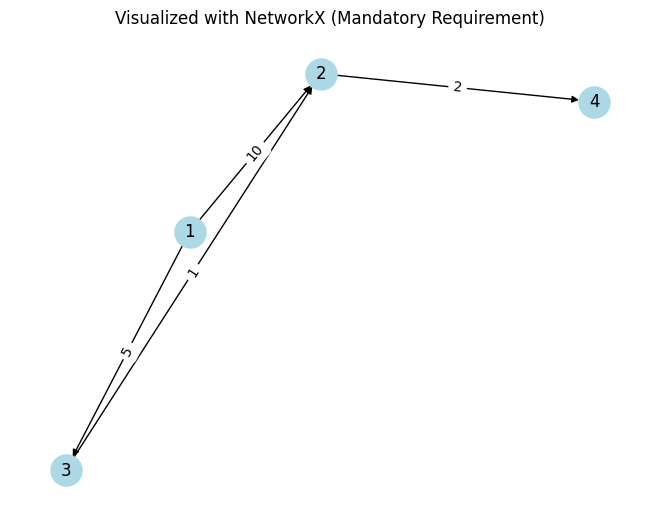

In [4]:
print("=== CHECKLIST VERIFICATION ===")

# 1. Graph Representations
print("\n[V] 1. Graph Representations (List & Matrix)")
g = WeightedGraph()
g.add_arc([1, 2], 10); g.add_arc([1, 3], 5); g.add_arc([2, 4], 2); g.add_arc([3, 2], 1)
print_dict(g.graph)
print_matrix(g.vertices, g.get_matrix())

# 2. Prüfer Codes
print("[V] 2. Prüfer Codes")
tree = WeightedGraph()
tree.add_arc([1,4]); tree.add_arc([4,1]); tree.add_arc([4,2]); tree.add_arc([2,4])
tree.add_arc([4,3]); tree.add_arc([3,4]); tree.add_arc([3,5]); tree.add_arc([5,3])
print(f"   Code for tree: {tree.prufer_code()}")

# 3. Search (DFS & BFS)
print("\n[V] 3. Graph Search")
print(f"   BFS from 1: {g.bfs(1)}")
print(f"   DFS from 1: {g.dfs(1)}")

# 4. Applications (Acyclicity & Bipartiteness)
print("\n[V] 4. Selected Applications")
print(f"   Is Bipartite? {g.is_bipartite()} (Expected: False due to triangle/structure)")
# Creating a DAG for acyclicity check
dag = WeightedGraph()
dag.add_arc([1,2]); dag.add_arc([2,3])
print(f"   DAG Check (via TopoSort): {dag.topological_sort()}")

# 5. Topological Sort & SCC
print("\n[V] 5. Topo Sort & Strongly Connected Components")
print(f"   Topo Sort (g): {g.topological_sort()} (Cycle detected expected)")
sccs = g.strongly_connected_components()
print(f"   Strongly Connected Components (Kosaraju): {sccs}")

# 6. Minimal Spanning Tree
print("\n[V] 6. MST (Prim)")
print(f"   MST from 1: {g.mst_prim(1)}")

# 7. Single-Source Shortest Paths
print("\n[V] 7. Single-Source Shortest Paths (Dijkstra)")
print(f"   Dijkstra from 1: {g.dijkstra(1)}")

# 8. All-Pairs Shortest Paths
print("\n[V] 8. All-Pairs Shortest Paths (Floyd-Warshall)")
dist_matrix = g.floyd_warshall()
print(f"   Dist 1->4: {dist_matrix[1][4]}")

# 9. Maximum Flow (Edmonds-Karp)
print("\n[V] 9. Max Flow (Edmonds-Karp)")
ek_flow = g.MaxFlow_EK(1, 4)
print(f"   Max Flow EK (1->4): {ek_flow}")

# 10. Python Graph Packages
print("\n[V] 10. Python Graph Packages (NetworkX)")
print("   Displaying graph...")
g.demo_networkx()

Dinitz

#The Dinitz Algorithm

### 1. Introduction: Why Dinitz?
For this project, I selected Dinitz's Algorithm to solve the Maximum Flow problem.

While the Edmonds-Karp algorithm is a fundamental approach, it can be inefficient for large or complex networks. Dinitz provides a sophisticated optimization that drastically reduces the running time by changing how we find augmenting paths.

### 2. Comparison: Why is Dinitz faster than Edmonds-Karp?

The main difference lies in how they utilize the Graph Search (BFS/DFS) in each iteration:

* **Edmonds-Karp ($O(V E^2)$):**
    * Uses BFS to find the single shortest augmenting path in the residual graph.
    * Updates the flow along that one path.
    * Inefficiency: It repeats the BFS traversal for every single path. If there are 10 paths available, it runs BFS 10 times.

* **Dinitz Algorithm ($O(V^2 E)$):**
    * Uses BFS to identify all shortest paths simultaneously (building a "Level Graph").
    * Then, it pushes flow through all of these paths at once using DFS until they are blocked.
    * Efficiency: It handles multiple paths in a single "phase", reducing the total work significantly.

### 3. How does Dinitz work? (The Two Steps)
The algorithm runs in Phases. Each phase consists of two distinct steps until the sink is no longer reachable:

#### Step 1: The Level Graph (BFS)
First, we run a Breadth-First Search (BFS) from the source ($s$) on the residual graph.
* We assign a level to each node (its distance from $s$).
* We construct the Level Graph by keeping only the edges that go forward from a node at level $L$ to a node at level $L+1$.
* *Goal:* This filters out backward edges and cycles, ensuring we only focus on the shortest paths towards the sink ($t$).

#### Step 2: The Blocking Flow (DFS)
Once the Level Graph is built, we run a Depth-First Search (DFS) repeatedly to push flow.
* We look for paths from $s$ to $t$ strictly using the edges in the Level Graph.
* We push the maximum possible flow along a path and update residual capacities.
* Crucial Optimization: We remember which edges are saturated (dead ends) so the DFS doesn't visit them again in the same phase.
* This step continues until no more flow can be pushed through the Level Graph (a Blocking Flow).

In [8]:
print("=== PROJECT: DINITZ ALGORITHM EXAMPLE ===")

proj_g = WeightedGraph()
#Source connected to nodes
proj_g.add_arc([1, 2], 10)
proj_g.add_arc([1, 3], 10)
#Intermediate connections
proj_g.add_arc([2, 3], 2)
proj_g.add_arc([2, 4], 4)
proj_g.add_arc([2, 5], 8)
proj_g.add_arc([3, 5], 9)
#To Sink (6)
proj_g.add_arc([4, 6], 10)
proj_g.add_arc([5, 4], 6)
proj_g.add_arc([5, 6], 10)

print("Graph Structure:")
print_dict(proj_g.graph)

source = 1
sink = 6
print(f"Calculating Max Flow from {source} to {sink} using Dinitz...")
flow_result, max_flow_val = proj_g.MaxFlow_Dinitz(source, sink)

print("-" * 30)
print(f"FINAL MAX FLOW VALUE: {max_flow_val}")
print("-" * 30)
print("Detailed Flow distribution:")
for (u, v), f in flow_result.items():
    if f > 0 and (u, v) in proj_g.weights:
        cap = proj_g.weights[(u, v)]
        print(f"  Edge {u} -> {v}: Flow {f} / Capacity {cap}")

=== PROJECT: DINITZ ALGORITHM EXAMPLE ===
Graph Structure:
1 :  2  3
2 :  3  4  5
3 :  5
4 :  6
5 :  4  6
6 :
Calculating Max Flow from 1 to 6 using Dinitz...
------------------------------
FINAL MAX FLOW VALUE: 19
------------------------------
Detailed Flow distribution:
  Edge 1 -> 2: Flow 10 / Capacity 10
  Edge 1 -> 3: Flow 9 / Capacity 10
  Edge 2 -> 4: Flow 4 / Capacity 4
  Edge 2 -> 5: Flow 6 / Capacity 8
  Edge 3 -> 5: Flow 9 / Capacity 9
  Edge 4 -> 6: Flow 9 / Capacity 10
  Edge 5 -> 4: Flow 5 / Capacity 6
  Edge 5 -> 6: Flow 10 / Capacity 10
